In [25]:
# allows clustering of cellprofiler and harmony well-aggregated data, blasts and tubes

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import truncate
import seaborn as sns
from matplotlib.patches import Patch
from toxifate import *

# path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\CellProfiler\PerWell\blastsPolyByWellProfiler.csv"
#path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\Harmony\Nv6-PerWell\tubesProfiles.csv"
path = r"E:\OneDrive - National University of Ireland, Galway\CellPainting project data\Harmony\Nv6-PerWell\blastsProfiles.csv"
# path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\CellProfiler\PerWell\tubesPolyByWellProfiler.csv"
path = r"E:\OneDrive - National University of Ireland, Galway\CellPainting project data\CellProfiler\PerWell\blastsAllByWellProfiler.csv"
# path = r"D:\OneDrive - National University of Ireland, Galway\CellPainting project data\Harmony\Nv6-PerWell\blastsProfiles.csv"

fileName = path.rsplit("\\")[-1].rsplit(".")[0]
prof = pd.read_csv(path)

prof = prof.dropna(axis=1)


if "Metadata_Concentration (Image)" in prof.columns:
    prof.rename(
        columns={
            "Metadata_Concentration (Image)": "Concentration",
            "PlateID": "PlateName",
        },
        inplace=True,
    )
    prof["Count"] = prof["Count"] * 5
    file_type = "cellprofiler"
else:
    file_type = "harmony"

prof = prof.loc[prof["Count"] > 50]
# prof = prof.loc[prof['Concentration']==3000]
# keep only ATOR CERI and SIMV
# prof = prof.loc[prof['Compound'].isin(['ATOR','CERI','SIMV','IMAT'])]
prof.drop(
    columns=[
        "Unnamed: 0",
        "PlateName",
        "Object No in All cells no border",
        "Count",
        "Row",
        "Column",
    ],
    inplace=True,
    errors="ignore",
)

# filter out features with standard deviation > 1000, artifacts of RobustMAD
profFiltered = drop_high_variance(prof, 10)
meanProf = profFiltered.groupby(by=["Compound", "Concentration"]).median(
    numeric_only=True
)

High variance filter : 196 features dropped (12.997%)


In [26]:
if "tubes" in fileName:
    plotTitle = "C2C12 myotubes (" + file_type + ")"
else:
    plotTitle = "C2C12 myoblasts (" + file_type + ")"
"""
plt.rcParams.update({"figure.dpi": 400})
plt.title(plotTitle)

clustersMean = sch.linkage(
    meanProf, method="single", metric="jaccard", optimal_ordering=True
)

max_d = 100  # 0.15e18 for blasts

ax = sch.dendrogram(
    Z=clustersMean,
    p=3,
    labels=meanProf.index.values,
    orientation="right",
    leaf_font_size=2,
    leaf_rotation=0,
    truncate_mode="none",
    show_contracted=True,
    distance_sort=True,
    color_threshold=max_d,
)"""

'\nplt.rcParams.update({"figure.dpi": 400})\nplt.title(plotTitle)\n\nclustersMean = sch.linkage(\n    meanProf, method="single", metric="jaccard", optimal_ordering=True\n)\n\nmax_d = 100  # 0.15e18 for blasts\n\nax = sch.dendrogram(\n    Z=clustersMean,\n    p=3,\n    labels=meanProf.index.values,\n    orientation="right",\n    leaf_font_size=2,\n    leaf_rotation=0,\n    truncate_mode="none",\n    show_contracted=True,\n    distance_sort=True,\n    color_threshold=max_d,\n)'

In [27]:
meanProf = drop_correlated_columns(meanProf, 0.95, numeric=False)

regionColors, channelColors, classColors = FeatureColorMapping().getColors(
    meanProf, file_type
)
region_list, channel_list, class_list = FeatureColorMapping().getFeatureTypes(file_type)
region_map, channel_map, class_map = FeatureColorMapping().getFeatureMaps(
    region_list, channel_list, class_list
)

Correlation filter : 1063 features dropped (81% of total)
cellprofiler features selected


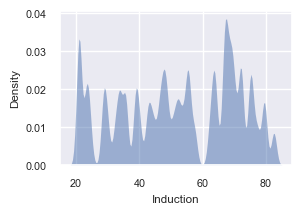

In [28]:
df = ComputeSampleInduction(meanProf)
df = df.loc[(df["Induction"] > 20)]

# flter rows for compound is ATOR CERI or SIMV
# df.reset_index(inplace=True)
# df = df.loc[df['Compound'].isin(['ATOR','CERI','SIMV','SUNI'])]
# df.set_index(['Compound','Concentration'], inplace=True)

# reduce the plot to a size of 400*200, and reduce font size
plt.figure(figsize=(3, 2))
sns.set(font_scale=0.7)
sns.kdeplot(
    x=df["Induction"],
    fill=True,
    bw_adjust=0.1,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)
plt.show()

# Replace values in the "Concentration" column by shorter strings
replacement_dict = {
    0: "0",
    10: "10",
    30: "30",
    100: "100",
    300: "300",
    1000: "1k",
    3000: "3k",
    10000: "10k",
    30000: "30k",
}

df.reset_index(inplace=True)
df["Concentration"] = df["Concentration"].replace(replacement_dict)
df = df.set_index(["Compound", "Concentration"])

# Z-score value clipping, for finer morphological changes
df = df.apply(lambda x: np.clip(x, -8, 8))

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


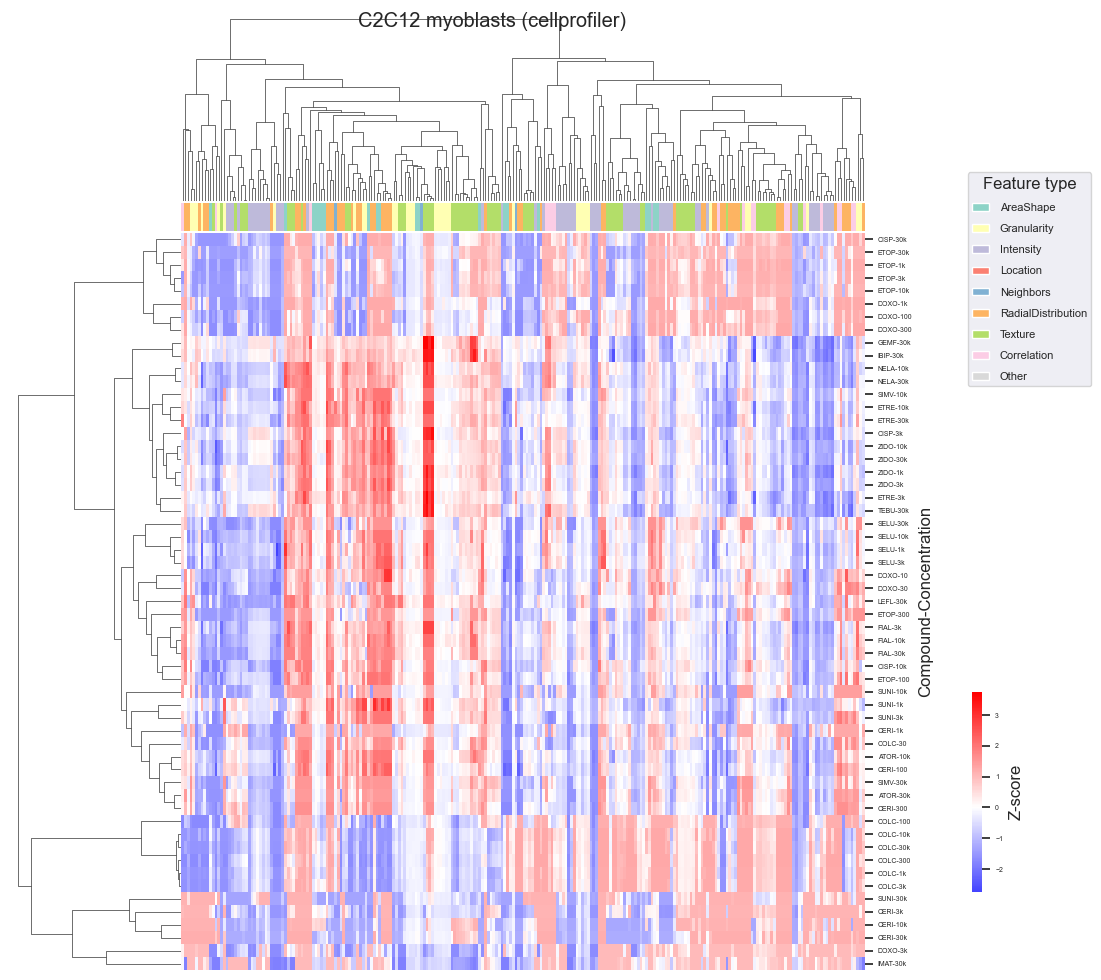

In [36]:
df.drop(columns=["Induction"], inplace=True, errors="ignore")

# colors = classColors # choose classColors, regionColors or channelColors
sns.set()
kws = dict(cbar_kws=dict(label="Z-score", orientation="vertical"))

drugColorMap = []
for i in range(len(df)):
    if df.index.get_level_values("Compound")[i] in [
        "NCAP",
        "ATOR",
        "CERI",
        "CLOF",
        "COLC",
        "DAPT",
    ]:
        drugColorMap.append("red")
    elif df.index.get_level_values("Compound")[i] in [
        "DEXA",
        "DOXO",
        "EZET",
        "HYCQ",
        "LEFL",
        "SELU",
    ]:
        drugColorMap.append("blue")
    elif df.index.get_level_values("Compound")[i] in [
        "CLEV",
        "ETOP",
        "FIAL",
        "GEMF",
        "IBIP",
        "MCPP",
    ]:
        drugColorMap.append("green")
    elif df.index.get_level_values("Compound")[i] in [
        "ETHF",
        "ETRE",
        "NELA",
        "SIMV",
        "VORI",
        "WURS",
    ]:
        drugColorMap.append("orange")
    elif df.index.get_level_values("Compound")[i] in [
        "CISP",
        "IMAT",
        "OLAN",
        "SUNI",
        "TEBU",
        "ZIDO",
    ]:
        drugColorMap.append("purple")
    else:
        drugColorMap.append("black")

ax = sns.clustermap(
    df,
    row_cluster=True,
    col_cluster=True,
    col_colors = classColors,
    #col_colors=[classColors, channelColors, regionColors],
    # row_colors = drugColorMap,
    z_score=False,
    metric="correlation",
    cmap="bwr",
    xticklabels=False,
    yticklabels=True,
    method="average",
    center=0.0,
    robust=False,
    **kws
)

x0, _y0, _w, _h = ax.cbar_pos
ax.ax_cbar.set_position([0.98, 0.10, 0.01, 0.2])
ax.ax_cbar.tick_params(axis="x", length=10)
ax.tick_params(axis="y", which="both", labelsize=5)
ax.fig.suptitle(plotTitle)
# resize the image
# ax.fig.set_size_inches(1, 1)


# Create a list of Patch objects with the corresponding colors for each category
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create a list of handles and labels for each color group
class_handles = [Patch(facecolor=class_map[name]) for name in class_list]
class_labels = class_list

channel_handles = [Patch(facecolor=channel_map[name]) for name in channel_list]
channel_labels = channel_list

region_handles = [Patch(facecolor=region_map[name]) for name in region_list]
region_labels = region_list

# Create a list of column titles
column_titles = ["Feature class", "Channel", "Region"]

# Create the legend using the handles and labels for each color group
import matplotlib.lines as mlines

# Create line separators
class_line = mlines.Line2D([], [], color="gray", linestyle="-")
channel_line = mlines.Line2D([], [], color="gray", linestyle="-")
region_line = mlines.Line2D([], [], color="gray", linestyle="-")

# Place the legend outside of the plot and resize it
handles = (
    class_handles + [class_line] + channel_handles + [channel_line] + region_handles
)
handles = class_handles
labels = class_labels + [""] + channel_labels + [""] + region_labels

# Place the legend outside of the plot and resize it
plt.legend(
    handles,
    labels,
    title="Feature type",
    bbox_to_anchor=(0.97, 0.6),
    bbox_transform=ax.fig.transFigure,
    loc="lower left",
    ncol=1,
    columnspacing=1,
    handletextpad=1,
    handlelength=1.5,
    labelspacing=1,
    prop={"size": 8},
)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


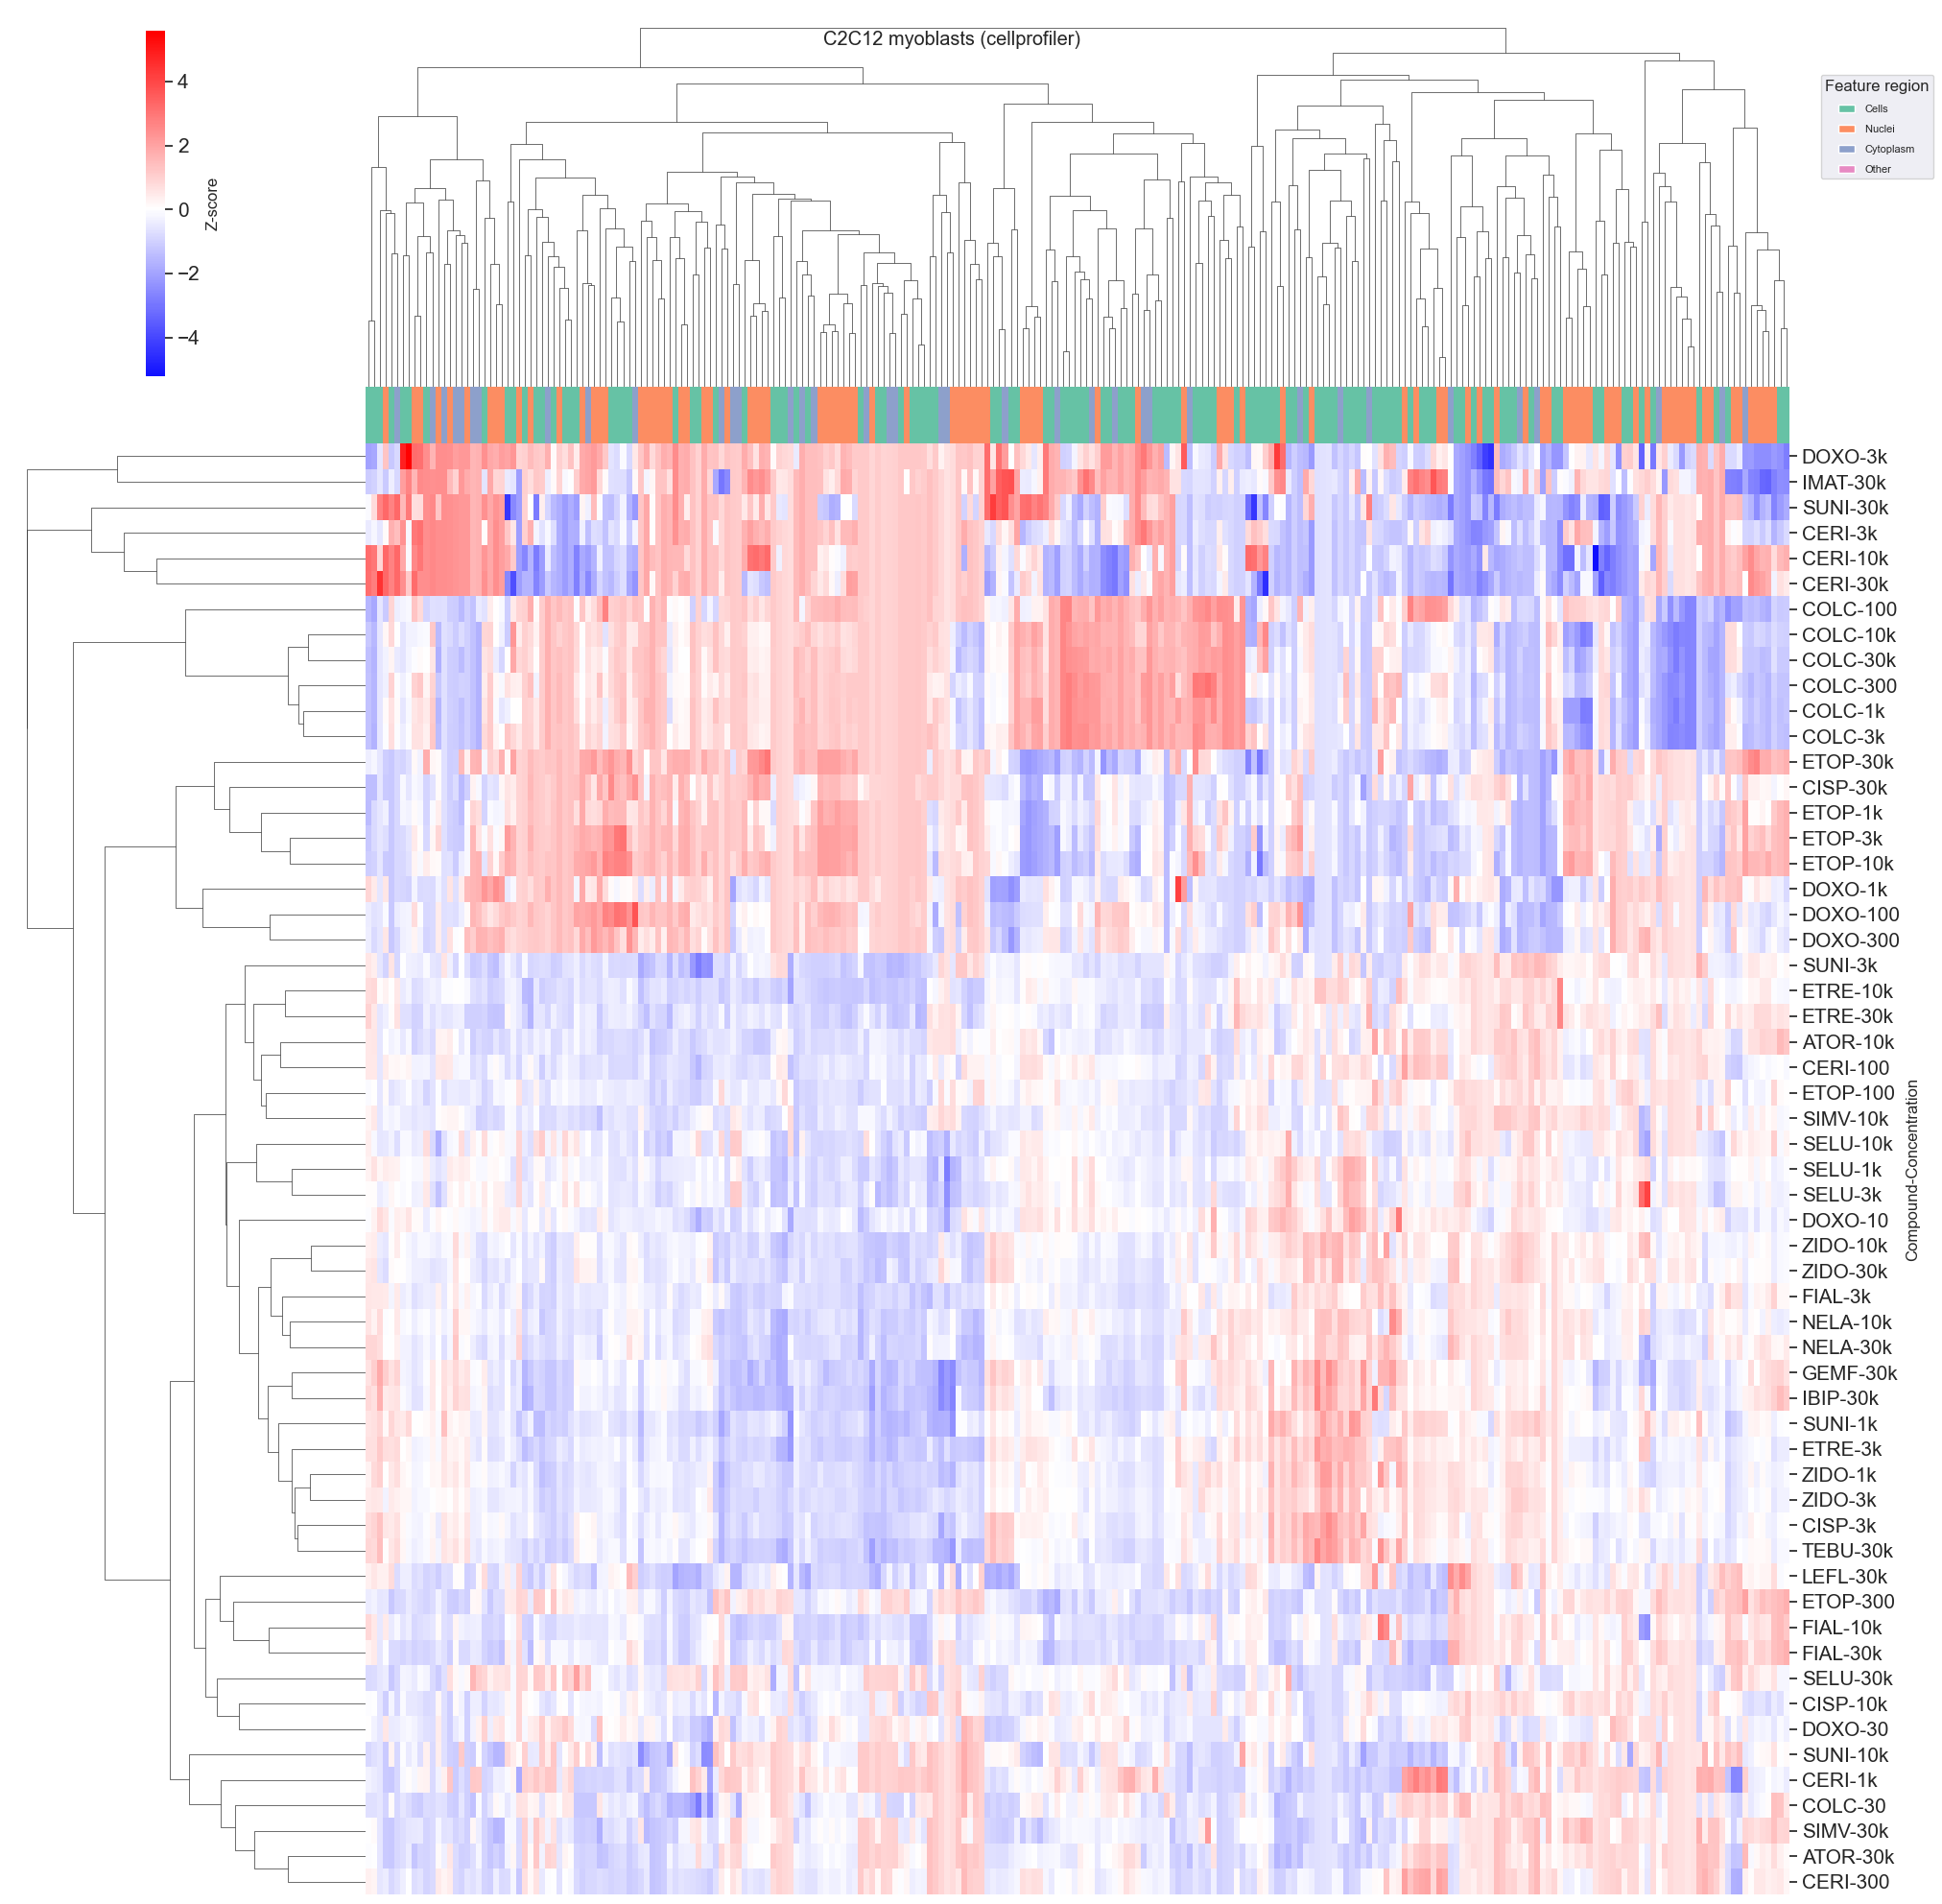

In [30]:
handles = region_handles
sns.set_theme(font_scale=1)
ax = sns.clustermap(
    df,
    row_cluster=True,
    col_cluster=True,
    col_colors = regionColors,
    #col_colors=[classColors, channelColors, regionColors],
    # row_colors = drugColorMap,
    z_score=True,
    metric="Euclidean",
    cmap="bwr",
    xticklabels=False,
    yticklabels=True,
    method="average",
    center=0.0,
    robust=False,
    figsize=(20, 20),
    **kws
)

x0, _y0, _w, _h = ax.cbar_pos
ax.ax_cbar.set_position([0.08, 0.80, 0.01, 0.18])
ax.ax_cbar.tick_params(axis="x", length=10)
ax.tick_params(axis="y", which="both", labelsize=15)
ax.fig.suptitle(plotTitle)
# resize the image
# ax.fig.set_size_inches(1, 1)

# Place the legend outside of the plot and resize it
plt.legend(
    handles,
    region_labels,
    title="Feature region",
    bbox_to_anchor=(0.95, 0.9),
    bbox_transform=ax.fig.transFigure,
    loc="lower left",
    ncol=1,
    columnspacing=1,
    handletextpad=1,
    handlelength=1.5,
    labelspacing=1,
    prop={"size": 8},
)

#save plot as tif
plt.savefig("E:\OneDrive - National University of Ireland, Galway\Figures\FigS7.tif", dpi=200, pil_kwargs=dict(compression='tiff_lzw'))